# Part 1: Feature and model selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## 1. Setting train and test set

In [2]:
train_data = pd.read_csv("../data/vct_2023/processed_data/AvsB_train_data_players_stats_eco_SK_rounds.csv")
test_data = pd.read_csv("../data/vct_2023/processed_data/AvsB_test_data_players_stats_eco_SK_rounds.csv")

In [3]:
game_id_columns = ["Tournament", "Stage", "Match Type", "Match Name", "Team_A", "Team_B"]
map_composition = ["Map", "Composition_A", "Composition_B"]
outcome_columns = ["Team_A_score_diff", "Team_B_score_diff", "Team_A_win", "Team_B_win"]

In [4]:
train_input = train_data.drop(game_id_columns+map_composition+outcome_columns, axis=1)
train_target = train_data["Team_A_win"]

test_input = test_data.drop(game_id_columns+map_composition+outcome_columns, axis=1)
test_target = test_data["Team_A_win"]

In [5]:
# Sanity check
assert len(train_input.keys()) == len(test_input.keys()), "The number of train and test input are different."
assert set(train_input.keys()) == set(test_input.keys()), "Train and test have different input feature."
assert len(train_input) == len(train_target), "Train input and target sizes are different."
assert len(test_input) == len(test_target), "Test input and target sizes are different."

In [6]:
# Check if input has non numeric features.
from pandas.api.types import is_numeric_dtype

for key in train_input.keys():
    if not is_numeric_dtype(train_input[key]):
        print(key, "is not numeric.")

## 2. Feature selection by using XGB

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier



In [8]:
xgb = XGBClassifier()
xgb.fit(train_input, train_target)
y_pred = xgb.predict(test_input)
xgb_acc = accuracy_score(test_target, y_pred)
print("Default XGB accuracy:", xgb_acc)

importance = xgb.feature_importances_
feature_importance = dict(zip(train_input.keys(), importance))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)


sorted_important_features = [x[0] for x in sorted_features]
most_important_features = sorted_important_features[:40]
print("Top 40 important features:")
print(most_important_features)

Default XGB accuracy: 0.6547619047619048
Top 40 important features:
['eco_rating_A', 'R1_lo_A', 'Average Combat Score_B', 'cont_Rating_B', 'sent_Rating_B', 'Kills Per Round_B', 'Kills Per Round_A', 'Average Combat Score_A', 'Clutch Success %_A', 'sent_Clutch Success %_A', 'R13_lo_B', 'duel_Average Combat Score_A', 'R6_Special_Kills_B', 'Rating_A', 'R4_Special_Kills_A', 'First Kills Per Round_A', 'Rating_B', 'sent_Rating_A', 'R3_lo_A', 'cont_Assists Per Round_B', 'sent_Kills Per Round_B', 'duel_Rating_A', 'Kill, Assist, Trade, Survive %_A', 'init_First Kills Per Round_A', 'R1_Special_Kills_A', 'duel_Average Damage Per Round_B', 'cont_Headshot %_B', 'R11_lo_B', 'Assists Per Round_A', 'R6_lo_B', 'R3_lo_B', 'prob_eco_rating_A', 'sent_Kills Per Round_A', 'cont_Average Combat Score_A', 'cont_Kills Per Round_B', 'eco_rating_B', 'sent_Average Damage Per Round_B', 'R10_Special_Kills_A', 'init_Assists Per Round_B', 'R4_lo_B']


### Let's use sorted important features to get the best subset of features.

In [9]:
# Find accuracy on the test set of each model:
# LogisticRegression, KNeighborsClassifier, DecisionTree, RandomForest, GradientBoostingClassifier, and XGBoostClassifier

best_acc = 0
best_features = None
best_clf = None
second_best_acc = 0
second_best_features = None
second_best_clf = None

acc_dict = {
    "number_of_features":[],
    "Logreg_acc":[],
    "KNN_acc":[],
    "DTree_acc":[],
    "RForest_acc":[],
    "XGB_acc":[]
    }

model_acc_df = pd.DataFrame(acc_dict)

for i in range(len(sorted_important_features)):
    '''
    We take only one pair of players' stats at a time and train models.
    We will do train test split on the train set to address data leakage issue.
    '''
    features = sorted_important_features[:i+1]

    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())])

    pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('KNN', KNeighborsClassifier())])
    
    dict_classifiers = {
        "Logreg": pipeline,
        "KNN": pipeline2,
        "DTree": DecisionTreeClassifier(),
        "RForest": RandomForestClassifier(),
        "XGB": XGBClassifier()
        }
    
    X_train = train_input[features]
    y_train = train_target
    X_test = test_input[features]
    y_test = test_target

    row_dict = {}
    row_dict['number_of_features'] = i+1

    for clf_name, clf in dict_classifiers.items():
        clf.fit(X_train, y_train)
        test_pred = clf.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)

        row_dict[f"{clf_name}_acc"] = test_acc

        if test_acc >= best_acc:
            temp_acc = best_acc
            best_acc = test_acc
            second_best_acc = temp_acc

            temp_features = best_features
            best_features = features
            second_best_features = temp_features

            temp_clf = best_clf
            best_clf = clf
            second_best_clf = temp_clf
        
    # Uncomment the lines below to see
    # accuracies and prediction means of validation set and test set in each step
    # 
    #     print("----------------------------------------")
    #     print(f"Classifier: {clf_name}")
    #     print(f"trained on {features}")
    #     print(" - - - - - - - - - - - - - - - - -")
    #     print(f"Validation accuracy: {val_acc}")
    #     print(f"y_val mean: {np.mean(y_val)}")
    #     print(f"Validation prediction mean: {np.mean(val_pred)}")
    #     print(" - - - - - - - - - - - - - - - - -")
    #     print(f"Test accuracy: {test_acc}")
    #     print(f"y_test mean: {np.mean(y_test)}")
    #     print(f"Test prediction mean: {np.mean(test_pred)}")

    # print("===============================================")
        
    # Add each models accuracies to model_acc_df
    model_acc_df = model_acc_df._append(row_dict, ignore_index=True)



In [10]:
model_acc_df

,number_of_features,Logreg_acc,KNN_acc,DTree_acc,RForest_acc,XGB_acc
0,1.0,0.583333,0.607143,0.607143,0.595238,0.607143
1,2.0,0.583333,0.571429,0.619048,0.642857,0.559524
2,3.0,0.559524,0.607143,0.619048,0.571429,0.547619
3,4.0,0.571429,0.595238,0.583333,0.583333,0.607143
4,5.0,0.559524,0.619048,0.547619,0.559524,0.571429
...,...,...,...,...,...,...
159,160.0,0.583333,0.452381,0.595238,0.559524,0.654762
160,161.0,0.583333,0.440476,0.630952,0.571429,0.654762
161,162.0,0.607143,0.452381,0.595238,0.607143,0.654762
162,163.0,0.607143,0.464286,0.607143,0.571429,0.654762


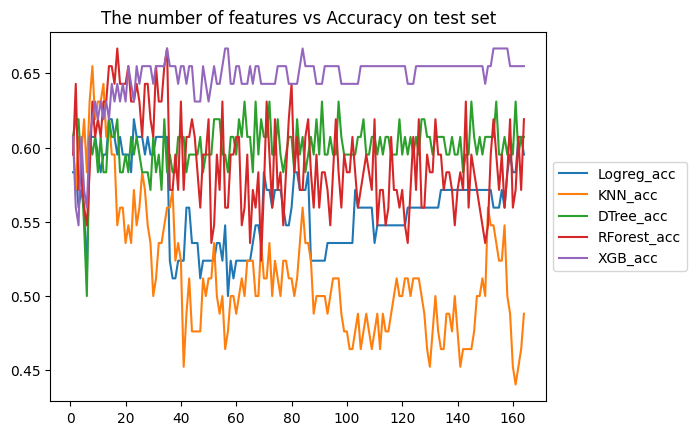

In [11]:
# Plot accuracy of each model when we increase the number of features.
plt.title("The number of features vs Accuracy on test set")
plt.plot(model_acc_df.number_of_features, model_acc_df["Logreg_acc"], label="Logreg_acc")
plt.plot(model_acc_df.number_of_features, model_acc_df["KNN_acc"], label="KNN_acc")
plt.plot(model_acc_df.number_of_features, model_acc_df["DTree_acc"], label="DTree_acc")
plt.plot(model_acc_df.number_of_features, model_acc_df["RForest_acc"], label="RForest_acc")
plt.plot(model_acc_df.number_of_features, model_acc_df["XGB_acc"], label="XGB_acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [12]:
len(best_features), len(second_best_features)

(158, 157)

In [13]:
best_clf, best_acc

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 0.6666666666666666)

In [14]:
second_best_clf, second_best_acc

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 0.6666666666666666)

In [15]:
feature_list = []
importance_list = []
for feature, importance in sorted_features:
    feature_list.append(feature)
    importance_list.append(importance)

importance_df = pd.DataFrame({"feature":feature_list, "importance":importance_list})

print("First 10 important features")
importance_df[:11]

First 10 important features


,feature,importance
0,eco_rating_A,0.197997
1,R1_lo_A,0.034085
2,Average Combat Score_B,0.031170
3,cont_Rating_B,0.030136
4,sent_Rating_B,0.029330
5,Kills Per Round_B,0.027321
6,Kills Per Round_A,0.026819
7,Average Combat Score_A,0.024581
8,Clutch Success %_A,0.023798
9,sent_Clutch Success %_A,0.023263


### Let's see what happens if we don't use engineered features.

In [16]:
# The following players_stats are not engineered.
# They are directly extracted from "players_stats.csv" file from Kaggle.
# We simply calculate the sum of the ratings for five players and assign this total to a team.
# (See "vct_2023_final_data_processing.ipynb")

players_stats = ["Rating_A", "Rating_B","Average Combat Score_A", "Average Combat Score_B",
                "Kill, Assist, Trade, Survive %_A", "Kill, Assist, Trade, Survive %_B",
                "Average Damage Per Round_A", "Average Damage Per Round_B",
                "Kills Per Round_A", "Kills Per Round_B",
                "Assists Per Round_A", "Assists Per Round_B",
                "First Kills Per Round_A", "First Kills Per Round_B",
                "First Deaths Per Round_A", "First Deaths Per Round_B",
                "Headshot %_A", "Headshot %_B",
                "Clutch Success %_A", "Clutch Success %_B"]


best_acc = 0
best_features = None
best_clf = None
second_best_acc = 0
second_best_features = None
second_best_clf = None

for i in range(len(players_stats)):
    '''
    We take only one pair of players' stats at a time and train models.
    We will do train test split on the train set to address data leakage issue.
    '''
    features = players_stats[:i+1]

    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())])

    pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('KNN', KNeighborsClassifier())])
    
    dict_classifiers = {
        "Logreg": pipeline,
        "KNN": pipeline2,
        "DTree": DecisionTreeClassifier(),
        "RForest": RandomForestClassifier(),
        "XGB": XGBClassifier()
        }
    
    X_train = train_input[features]
    y_train = train_target
    X_test = test_input[features]
    y_test = test_target

    for clf_name, clf in dict_classifiers.items():
        clf.fit(X_train, y_train)
        test_pred = clf.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)


        if test_acc >= best_acc:
            temp_acc = best_acc
            best_acc = test_acc
            second_best_acc = temp_acc

            temp_features = best_features
            best_features = features
            second_best_features = temp_features

            temp_clf = best_clf
            best_clf = clf
            second_best_clf = temp_clf

    #     print("----------------------------------------")
    #     print(f"Classifier: {clf_name}")
    #     print(f"trained on {features}")
    #     print(" - - - - - - - - - - - - - - - - -")
    #     print(f"Validation accuracy: {val_acc}")
    #     print(f"y_val mean: {np.mean(y_val)}")
    #     print(f"Validation prediction mean: {np.mean(val_pred)}")
    #     print(" - - - - - - - - - - - - - - - - -")
    #     print(f"Test accuracy: {test_acc}")
    #     print(f"y_test mean: {np.mean(y_test)}")
    #     print(f"Test prediction mean: {np.mean(test_pred)}")
        
    # print("===============================================")

In [17]:
best_features, second_best_features

(['Rating_A'], ['Rating_A'])

In [18]:
best_clf, best_acc, second_best_clf, second_best_acc

(RandomForestClassifier(),
 0.6785714285714286,
 Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())]),
 0.6666666666666666)

### What if we use eco_ratings with not engineered features?

In [19]:
eco_players_stats = ["eco_rating_A", "eco_rating_B"] + ["Rating_A", "Rating_B","Average Combat Score_A", "Average Combat Score_B",
                "Kill, Assist, Trade, Survive %_A", "Kill, Assist, Trade, Survive %_B",
                "Average Damage Per Round_A", "Average Damage Per Round_B",
                "Kills Per Round_A", "Kills Per Round_B",
                "Assists Per Round_A", "Assists Per Round_B",
                "First Kills Per Round_A", "First Kills Per Round_B",
                "First Deaths Per Round_A", "First Deaths Per Round_B",
                "Headshot %_A", "Headshot %_B",
                "Clutch Success %_A", "Clutch Success %_B"]


best_acc = 0
best_features = None
best_clf = None
second_best_acc = 0
second_best_features = None
second_best_clf = None

for i in range(len(eco_players_stats)):
    '''
    We take only one pair of players' stats at a time and train models.
    We will do train test split on the train set to address data leakage issue.
    '''
    features = eco_players_stats[:i+1]

    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())])

    pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('KNN', KNeighborsClassifier())])
    
    dict_classifiers = {
        "Logreg": pipeline,
        "KNN": pipeline2,
        "DTree": DecisionTreeClassifier(),
        "RForest": RandomForestClassifier(),
        "XGB": XGBClassifier()
        }
    
    X_train = train_input[features]
    y_train = train_target
    X_test = test_input[features]
    y_test = test_target

    for clf_name, clf in dict_classifiers.items():
        clf.fit(X_train, y_train)
        test_pred = clf.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)

        if test_acc >= best_acc:
            temp_acc = best_acc
            best_acc = test_acc
            second_best_acc = temp_acc

            temp_features = best_features
            best_features = features
            second_best_features = temp_features

            temp_clf = best_clf
            best_clf = clf
            second_best_clf = temp_clf



In [20]:
len(best_features), len(second_best_features)

(21, 20)

In [21]:
best_clf, best_acc, second_best_clf, second_best_acc

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 0.6785714285714286,
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
      

### Conclusion of Part 1:

With engineered features: XGBoost performed the best with 0.666 accuracy, trained on 158 features.

With non_engineered features: RandomForest performed the best with 0.678 accuracy, trained on one feature 'Rating_A'.

With eco_rating and non_engineered features: XGBoost performed the best with 0.678 accuracy, trained on 21 features.

# Part 2: Parameter tuning

In Part 1, we found two models, XGBoostClassifier and RandomForest, which performed better than other.

Since XGBoostClassifier trained on a lot of features, we will try to do hyperparameter tuning on XGBoost to increase accuracy on the test set.

Instead of using 158 engineered features, we will use non_engineered features together with eco_ratings because XGB showed promising performance with this subset.

In [22]:
eco_players_stats = ["eco_rating_A", "eco_rating_B"] + ["Rating_A", "Rating_B","Average Combat Score_A", "Average Combat Score_B",
                "Kill, Assist, Trade, Survive %_A", "Kill, Assist, Trade, Survive %_B",
                "Average Damage Per Round_A", "Average Damage Per Round_B",
                "Kills Per Round_A", "Kills Per Round_B",
                "Assists Per Round_A", "Assists Per Round_B",
                "First Kills Per Round_A", "First Kills Per Round_B",
                "First Deaths Per Round_A", "First Deaths Per Round_B",
                "Headshot %_A", "Headshot %_B",
                "Clutch Success %_A", "Clutch Success %_B"]


X_train = train_input[eco_players_stats]  
X_test = test_input[eco_players_stats]
y_train = train_target
y_test = test_target

In [23]:
# Default parameters
# n_estimators_list = [100]
# learning_rate_list = [0.3]
# max_depth_list = [6]
# They gave 0.66 accuracy

# Set parameter grid
n_estimators_list = np.arange(250,1200,50)
learning_rate_list = np.arange(1,2,0.1)
max_depth_list = np.arange(1,6,1)

best_accuracy = 0
best_params = {}

# Iterate over hyperparameter combinations
for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        for max_depth in max_depth_list:
            # Initialize XGBClassifier with current hyperparameters
            clf = XGBClassifier(n_estimators=n_estimators,
                                             learning_rate=learning_rate,
                                             max_depth=max_depth)
            # Train the classifier on the training data
            clf.fit(X_train, y_train)
            
            # Evaluate the classifier on the test set
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            # Check if current hyperparameters yield better accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'n_estimators': n_estimators,
                               'learning_rate': learning_rate,
                               'max_depth': max_depth}

# Train the final classifier with the best hyperparameters on the entire training set
final_clf = XGBClassifier(**best_params)
final_clf.fit(X_train, y_train)

# Evaluate the final classifier on the test set
y_test_pred = final_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'n_estimators': 250, 'learning_rate': 1.0, 'max_depth': 4}
Test Accuracy: 0.6904761904761905


### List of significant parameters and their accuracies
```python
Best Hyperparameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 2}\
Test Accuracy: 0.6785714285714286

Best Hyperparameters: {'n_estimators': 250, 'learning_rate': 1, 'max_depth': 4}\
Test Accuracy: 0.6904761904761905

Best Hyperparameters: {'n_estimators': 250, 'learning_rate': 0.75, 'max_depth': 5}\
Test Accuracy: 0.6904761904761905

Best Hyperparameters: {'n_estimators': 300, 'learning_rate': 0.75, 'max_depth': 5}\
Test Accuracy: 0.6904761904761905

Best Hyperparameters: {'n_estimators': 250, 'learning_rate': 1.0, 'max_depth': 4}\
Test Accuracy: 0.6904761904761905

Best Hyperparameters: {'n_estimators': 300, 'learning_rate': 1.25, 'max_depth': 1}\
Test Accuracy: 0.7023809523809523
```



### Conclusion of Part 2:

*After hyperparameter tuning, `XGBClassifier` performed with up to `70% accuracy`!*\
Interestingly, increasing the number of estimators didn't improve accuracy when it exceeded 300.